In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.stats import ortho_group
from scipy import fft
import copy 
from main import load_test_ecg, load_train_ecg
np.random.seed(0)

First we use the training dataset to get a representation of the source. The parameters are
- n\_features = patch size of the input signal
- n\_components = number of components to use in the GMM
- n\_test = number of test samples to use to test the reconstructions
- n\_samples = number of samples to use to train the GMM
- n\_measurements = number of measurements to use in the reconstruction

First we perform a sanity check of the reconstructions using the minimum MSE estimate of using Statistical Compressed Sensing

In [2]:
n_components = 5
n_features = 60
n_samples = 10000
n_test = 2000
n_measurements = ((n_features * 5) // 10) # 50% of the features

measurement_matrices = []
for i in range(10):
    measurement_matrices.append(np.random.randn(n_measurements, n_features))
    # measurement_matrices.append(np.random.binomial(1, 0.5, size=(n_measurements, n_features)))

samples = load_train_ecg(path = 'data/ecg/mitbih_train.csv',num=n_samples, patch_size=n_features)
# estimated_gmm is fitted on the training data
estimated_gmm = GaussianMixture(n_components=n_components,  n_init=5, verbose=1, max_iter=200, init_params='random')
estimated_gmm.fit(samples)

samples = load_train_ecg(path = 'data/ecg/mitbih_test.csv',num=n_test, patch_size=n_features)
compressed_measurements = []
sample_measurement_matrix = []
for i in range(n_test):
    matrix_index = np.random.randint(0, len(measurement_matrices))
    sample_measurement_matrix.append(matrix_index)
    compressed_measurements.append(np.dot(measurement_matrices[matrix_index], samples[i]))

noise_std_dev = 0.0005
noise_covariance_matrix = np.eye(n_measurements) * (noise_std_dev * noise_std_dev)
compressed_measurements = np.array(compressed_measurements)
comp_copy = compressed_measurements.copy()
compressed_measurements += np.random.normal(0, noise_std_dev, compressed_measurements.shape)
print(compressed_measurements.shape)
print(samples.shape)
print(measurement_matrices[0].shape)
print(len(sample_measurement_matrix))

diff = 0
for i in range(compressed_measurements.shape[0]):
    diff += np.linalg.norm(compressed_measurements[i] - comp_copy[i])

diff /= compressed_measurements.shape[0]
print(diff)




Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 1
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True
Initialization 2
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
Initialization converged: True
Initialization 3
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 4
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
(2000, 30)
(2000, 60)
(30, 60)
2000
0.0027212867998001643


Here the ``form_y_gmms`` functions returns the GMMs for each measurement matrix 
As described in the paper 
\begin{align*}
    p(\mathbf{y} | \Theta) &= \sum_{i}^{K} \pi_z \mathcal{N} (\mathbf{y} | \pmb{\phi}_i \mathbf{\mu}_z, \mathbf{R}_z (\Theta) ) 
\end{align*}


In [3]:
# for each of the 10 measurement matrices we have a separate gmm in the y-domain so let us make all of them p(y|z)

def form_y_gmms(x_gmm, measurement_matrices, noise_covariance_matrix):
    gmm_list = []
    noise_inverse = np.linalg.inv(noise_covariance_matrix)
    for i in range(len(measurement_matrices)):
        gmm_sample = GaussianMixture(n_components=n_components, random_state=0)
        gmm_sample.means_ = x_gmm.means_ @ measurement_matrices[i].T
        covariance_array = []

        for j in range(n_components):
            # C_ij = np.linalg.pinv(measurement_matrices[i].T @ noise_inverse @ measurement_matrices[i] + x_gmm.precisions_[j])
            # temp_matrix = noise_inverse @ measurement_matrices[i] @ C_ij @ measurement_matrices[i].T @ noise_inverse
            # covariance_array.append(np.linalg.pinv(noise_inverse - temp_matrix))
            covariance_array.append(noise_covariance_matrix  + measurement_matrices[i] @ x_gmm.covariances_[j] @ measurement_matrices[i].T)

        gmm_sample.covariances_ = np.array(covariance_array)
        gmm_sample.weights_ = x_gmm.weights_

        precision_array = [np.linalg.pinv(covariance_array[i]) for i in range(n_components)]
        gmm_sample.precisions_ = np.array(precision_array)
        gmm_sample.precisions_cholesky_ = np.array([np.linalg.cholesky(precision_array[i]) for i in range(n_components)])
        
        gmm_list.append(gmm_sample)
    return gmm_list

In [4]:
def get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, gmm_list):
    log_likelihood = 0
    for i in range(compressed_measurements.shape[0]):
        # print(gmm_list[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
        log_likelihood += gmm_list[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1))

    return log_likelihood/len(compressed_measurements)

The following functions ``get_new_weights``, ``get_new_means``, ``get_new_covariances`` and ``get_x_reconstruction`` are used to perform the EM algorithm to update the GMMs based on the compressed measurements as described in equations 17-20 of the paper

In [5]:
def get_new_weights(compressed_measurements, y_gmms, sample_measurement_matrix, n_samples):
    # calculate p_ik
    new_weights = []
    for k in range(n_components):
        ssum = 0
        for i in range(n_samples):
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            ssum += p_ik
        new_weights.append(ssum)
    new_weights = np.array(new_weights)
    new_weights /= np.sum(new_weights)
    return new_weights

In [6]:
def get_x_reconstruction(measurement_matrix, noise_covariance_matrix, x_covariance_matrix, x_mean, compressed_measurement):
    """
    gets the x reconstruction for a compressed sample for the z^th component in x (specified by x_covariance_matrix and x_mean)
    """
    # noise_inverse = np.linalg.pinv(noise_covariance_matrix)
    # C_z = np.linalg.pinv(measurement_matrix.T @ noise_inverse @ measurement_matrix + x_precision_matrix)
    C_z = np.linalg.pinv(noise_covariance_matrix + (measurement_matrix @ x_covariance_matrix @ measurement_matrix.T))
    x_reconstruction = x_mean + (x_covariance_matrix @ measurement_matrix.T @ C_z @ (compressed_measurement - measurement_matrix @ x_mean))
    return x_reconstruction    

In [7]:
def get_new_means(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, n_samples):
    new_means = []
    for k in range(n_components):
        ssum = 0
        psum = 0
        for i in range(n_samples):
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            psum += p_ik
            n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[k], estimated_gmm.means_[k], compressed_measurements[i])
            ssum += p_ik * n_ik
        new_means.append(ssum/psum)
    new_means = np.array(new_means)
    return new_means

In [8]:
def get_new_covariances(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, new_means, n_samples):
    new_covariances = []
    for k in range(n_components):
        csum = 0
        psum = 0
        for i in range(n_samples):
            measurement_matrix = measurement_matrices[sample_measurement_matrix[i]]
            p_ik = y_gmms[sample_measurement_matrix[i]].weights_[k] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmms[sample_measurement_matrix[i]].means_[k], cov=y_gmms[sample_measurement_matrix[i]].covariances_[k]) / np.exp(y_gmms[sample_measurement_matrix[i]].score(compressed_measurements[i].reshape(1, -1)))
            psum += p_ik
            n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[k], estimated_gmm.means_[k], compressed_measurements[i])
            C_ik = estimated_gmm.covariances_[k] - (estimated_gmm.covariances_[k] @ measurement_matrix.T @ np.linalg.pinv(noise_covariance_matrix + (measurement_matrix @ estimated_gmm.covariances_[k] @ measurement_matrix.T)) @ measurement_matrix @ estimated_gmm.covariances_[k])
            csum += p_ik * (C_ik + (n_ik - new_means[k]).reshape(-1, 1) @ (n_ik - new_means[k]).reshape(1, -1))
        new_covariances.append(csum/psum)
    new_covariances = np.array(new_covariances)
    return new_covariances

First check if the reconstruction is good using the suggested method (compare Max-Max estimate (which was used by Nimay last sem) and MSE optimal estimate)

In [9]:
def weighted_l2(v, mat):
    if np.linalg.matrix_rank(mat) < mat.shape[0]:
        # handles the case where the matrix is not invertible
        m = v.T @ np.linalg.pinv(mat) @ v
    else:
        m = v.T @ np.linalg.inv(mat) @ v
    return m

In [10]:
def decode(model, A, y, noise_covariance_matrix):
    x_hat = np.empty(model.means_.shape)
    cost = []
    var_noise = noise_covariance_matrix

    for j in range(model.means_.shape[0]):
        var_j, mu_j = model.covariances_[j], model.means_[j]
        x_hat_j = var_j @ A.T @ np.linalg.pinv(A @ var_j @ A.T + var_noise) @ (y - A @ mu_j) + mu_j
        # print(np.linalg.det(var_j))
        # print(var_j)
        cost_j = weighted_l2(y - A @ x_hat_j, var_noise) + weighted_l2(x_hat_j - mu_j, var_j) + np.log(np.linalg.det(var_j))
        # print(np.linalg.det(var_j))
        x_hat[j] = x_hat_j
        cost.append(cost_j)

    j = np.argmin(cost)
    # print(j)
    return x_hat[j]

The error metric is the percent RMSE error

In [11]:
def error_metric(a, b, n_samples):
    err = 0
    for i in range(n_samples):
        err += np.linalg.norm(a[i] - b[i]) / np.linalg.norm(b[i])
    return err/n_samples

In [28]:
# min MSE scheme
reconstructed_samples = []
y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)

for i in range(n_test):
    y_gmm = y_gmms[sample_measurement_matrix[i]]
    reconstructed_sample = np.zeros(estimated_gmm.means_[0].shape)
    psum = 0
    for j in range(n_components):
        p_ik = y_gmm.weights_[j] * multivariate_normal.pdf(compressed_measurements[i], mean=y_gmm.means_[j], cov=y_gmm.covariances_[j]) / np.exp(y_gmm.score(compressed_measurements[i].reshape(1, -1)))
        psum += p_ik
        n_ik = get_x_reconstruction(measurement_matrices[sample_measurement_matrix[i]], noise_covariance_matrix, estimated_gmm.covariances_[j], estimated_gmm.means_[j], compressed_measurements[i])
        reconstructed_sample += p_ik * n_ik
    assert abs(psum - 1) < 1e-3
    reconstructed_samples.append(reconstructed_sample)

reconstructed_samples = np.array(reconstructed_samples)
print(f"Min MSE Mean RMSE: {error_metric(reconstructed_samples, samples, n_test)}")

# max-max scheme
mm_recon = []
for i in range(n_test):
    mm_recon.append(decode(estimated_gmm, measurement_matrices[sample_measurement_matrix[i]], compressed_measurements[i], noise_covariance_matrix))
mm_recon = np.array(mm_recon)
print(f"MM Mean RMSE: {error_metric(mm_recon, samples, n_test)}")

# comparision with DCT scheme (retaining the lowest n_measurements coefficients)
dct_recon = []
for i in range(n_test):
    tsfm = fft.dct(samples[i], norm='ortho')
    tsfm[n_measurements:] = 0
    dct_recon.append(fft.idct(tsfm, norm='ortho'))
dct_recon = np.array(dct_recon)
print(f"DCT Mean RMSE: {error_metric(dct_recon, samples, n_test)}")

Min MSE Mean RMSE: 0.031500404959697664
MM Mean RMSE: 0.03161160041413446
DCT Mean RMSE: 0.061858367139471085


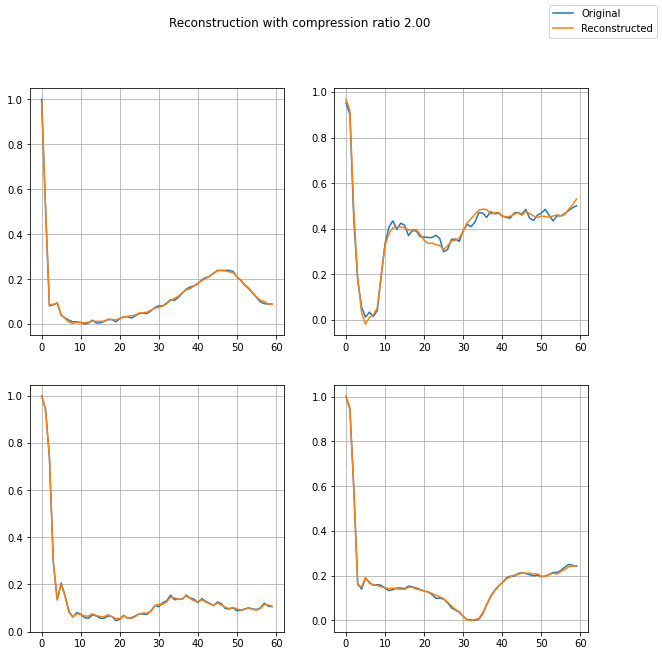

In [29]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
itc = 0
for i in (np.random.randint(0,n_test, size=4)):
    ax[itc//2,itc%2].plot(samples[i], label='Original')
    ax[itc//2,itc%2].plot(reconstructed_samples[i], label='Reconstructed')
    # ax[itc//2,itc%2].plot(dct_recon[i], 'x--', label='DCT')
    ax[itc//2,itc%2].grid()
    itc += 1    
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
comp_ratio  = n_features/n_measurements
fig.suptitle(f"Reconstruction with compression ratio {comp_ratio:.2f}")
plt.savefig(f"./plots/CR{comp_ratio:.2f}.png")
plt.show()

In [12]:
def get_random_unit_vector(n):
    v = np.random.normal(size=n)
    return v/np.linalg.norm(v)

## Drift in the GMM
Now we shift the trained GMM syntehtically by shifting their means using a error vector of norm atmost 15% of the norm of the mean vector

In [13]:
# utility function to shift gmm
def shift_gmm(original_gmm, fc):
    # shift means randomly by fc% of its norm and copy everything else as is
    for i in range(n_components):
        original_gmm.means_[i] = original_gmm.means_[i] + (fc * np.linalg.norm(original_gmm.means_[i]) * get_random_unit_vector(n_features))
        original_gmm.covariances_[i] = original_gmm.covariances_[i]
        original_gmm.precisions_[i] = original_gmm.precisions_[i]
        original_gmm.precisions_cholesky_[i] = original_gmm.precisions_cholesky_[i]
        original_gmm.weights_ = original_gmm.weights_

    return original_gmm

In [14]:
def test_updated_gmm(n_test, test_sample_set, my_test_gmm, estimated_gmm, measurement_matrices, noise_covariance_matrix):
    test_compressed_measurements = []
    test_sample_matrix_indices = []
    for i in range(n_test):
        matrix_index = np.random.randint(0, len(measurement_matrices))
        test_sample_matrix_indices.append(matrix_index)
        test_compressed_measurements.append(measurement_matrices[matrix_index] @ test_sample_set[i])

    test_reconstructed_samples = []
    test_reconstructed_samples_with_original_gmm = []
    y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
    y_gmms_orig = form_y_gmms(my_test_gmm, measurement_matrices, noise_covariance_matrix)

    for i in range(n_test):
        y_gmm = y_gmms[test_sample_matrix_indices[i]]
        y_gmm_orig = y_gmms_orig[test_sample_matrix_indices[i]]
        reconstructed_sample = np.zeros(estimated_gmm.means_[0].shape)
        reconstructed_sample_orig = np.zeros(my_test_gmm.means_[0].shape)
        psum = 0
        psum_orig = 0
        for j in range(n_components):
            p_ik = y_gmm.weights_[j] * multivariate_normal.pdf(test_compressed_measurements[i], mean=y_gmm.means_[j], cov=y_gmm.covariances_[j]) / np.exp(y_gmm.score(test_compressed_measurements[i].reshape(1, -1)))
            p_ik_orig = y_gmm_orig.weights_[j] * multivariate_normal.pdf(test_compressed_measurements[i], mean=y_gmm_orig.means_[j], cov=y_gmm_orig.covariances_[j]) / np.exp(y_gmm_orig.score(test_compressed_measurements[i].reshape(1, -1)))
            psum += p_ik
            psum_orig += p_ik_orig
            n_ik = get_x_reconstruction(measurement_matrices[test_sample_matrix_indices[i]], noise_covariance_matrix, estimated_gmm.covariances_[j], estimated_gmm.means_[j], test_compressed_measurements[i])
            n_ik_orig = get_x_reconstruction(measurement_matrices[test_sample_matrix_indices[i]], noise_covariance_matrix, my_test_gmm.covariances_[j], my_test_gmm.means_[j], test_compressed_measurements[i])
            reconstructed_sample += p_ik * n_ik
            reconstructed_sample_orig += p_ik_orig * n_ik_orig
        assert abs(psum - 1) < 1e-3
        assert abs(psum_orig - 1) < 1e-3
        test_reconstructed_samples.append(reconstructed_sample)
        test_reconstructed_samples_with_original_gmm.append(reconstructed_sample_orig)

    test_reconstructed_samples = np.array(test_reconstructed_samples)
    test_reconstructed_samples_with_original_gmm = np.array(test_reconstructed_samples_with_original_gmm)
    print(f"Test Mean RMSE post-update: {error_metric(test_sample_set, test_reconstructed_samples,n_test)}")
    print(f"Test Mean RMSE pre-update: {error_metric(test_sample_set, test_reconstructed_samples_with_original_gmm,n_test)}")
    return [test_reconstructed_samples_with_original_gmm[0], test_reconstructed_samples[0], error_metric(test_sample_set, test_reconstructed_samples,n_test), error_metric(test_sample_set, test_reconstructed_samples_with_original_gmm,n_test) ]

Measurements = 12 : Features = 60
(1000, 12)
Initial log likelihood:  -17.43868616734069
Iteration 1 log-likelihood: -14.325186267332233
Iteration 2 log-likelihood: -13.741148296465694
Iteration 3 log-likelihood: -13.41235162480811
Iteration 4 log-likelihood: -13.185987173093372
Iteration 5 log-likelihood: -13.008568392688497
Iteration 6 log-likelihood: -12.861174874731608
Iteration 7 log-likelihood: -12.733545170242682
Iteration 8 log-likelihood: -12.624616147346186
Iteration 9 log-likelihood: -12.526419417063549
Converged
Test Mean RMSE post-update: 0.2376735480685666
Test Mean RMSE pre-update: 0.2614926568071486
Measurements = 24 : Features = 60
(1000, 24)
Initial log likelihood:  -31.27830915001437
Cholesky decomposition failed due to singular covariance matrix - Stopping
Test Mean RMSE post-update: 0.18526002397895255
Test Mean RMSE pre-update: 0.2024336363107386
Measurements = 36 : Features = 60
(1000, 36)
Initial log likelihood:  -42.24545871127835
Iteration 1 log-likelihood: -2

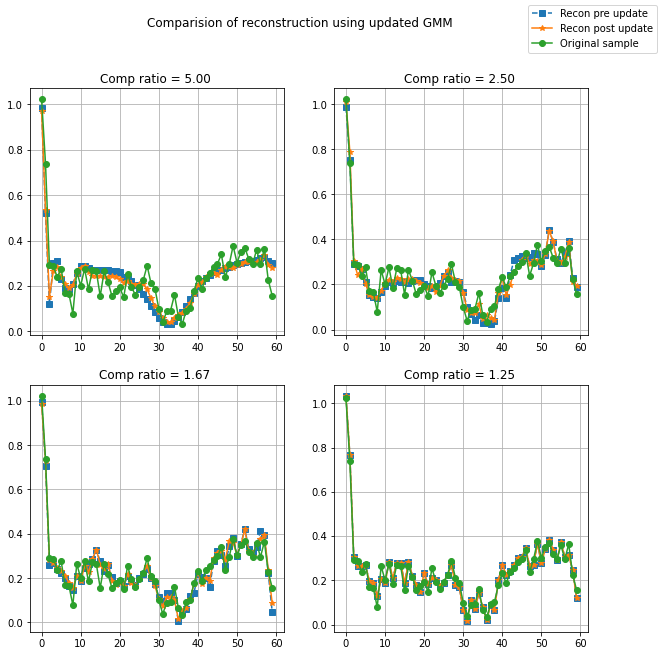

In [15]:
# generate samples from the gmm

my_test_gmm = copy.deepcopy(estimated_gmm)
my_test_gmm = shift_gmm(my_test_gmm, 0.15)

n_total = 1500
n_samples = 1000
n_test = n_total - n_samples
samples = my_test_gmm.sample(n_samples=n_total)[0]

measurement_matrix_sup = []
for i in range(10):
    measurement_matrix_sup.append(np.random.randn(n_features, n_features))
    # measurement_matrices.append(np.random.binomial(1, 0.5, size=(n_measurements, n_features))

# keep copy of current estimate
estimated_gmm_copy = copy.deepcopy(estimated_gmm)
last_iter_copy = copy.deepcopy(estimated_gmm)

# Test set for different compression ratios

test_sample_set = samples[n_samples - n_test:]
samples = samples[:n_samples]

fig, ax = plt.subplots(2,2, figsize=(10,10))

itc = 0
pre_update_rmse = []
post_update_rmse = []

for zeta in range(2,10,2):
# take measurements
    print(f"Measurements = {(zeta * n_features)//10} : Features = {n_features}")
    estimated_gmm = copy.deepcopy(estimated_gmm_copy)

    n_measurements = (zeta * n_features)// 10
    measurement_matrices = []
    for meas_matrix in measurement_matrix_sup:
        measurement_matrices.append(meas_matrix[:n_measurements])
    
    compressed_measurements = []
    sample_measurement_matrix = []
    for i in range(n_samples):
        matrix_index = np.random.randint(0, len(measurement_matrices))
        sample_measurement_matrix.append(matrix_index)
        compressed_measurements.append(np.dot(measurement_matrices[matrix_index], samples[i]))

    compressed_measurements = np.array(compressed_measurements)
    compressed_measurements += np.random.normal(0, noise_std_dev, compressed_measurements.shape)
    print(compressed_measurements.shape)

    # perform updates on the estimated gmm
    # log likelihoods stores the log likelihoods of the estimated gmm computed on the samples drawn from the original gmm, our objective is to maximise this
    tol = 0.1
    log_likelihoods = []
    noise_covariance_matrix = np.eye(n_measurements) * (noise_std_dev * noise_std_dev)
    y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
    log_likelihoods.append(get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, y_gmms))

    print("Initial log likelihood: ", log_likelihoods[-1])
    # ideal_log_likelihood = get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, form_y_gmms(my_test_gmm, measurement_matrices, noise_covariance_matrix))
    # print("Ideal log likelihood: ", ideal_log_likelihood)

    noise_inverse =  np.linalg.inv(noise_covariance_matrix)
    iter_counter = 0

    while True:

        new_weights = get_new_weights(compressed_measurements, y_gmms, sample_measurement_matrix,n_samples)
        new_means = get_new_means(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix,n_samples)
        new_covariances = get_new_covariances(compressed_measurements, y_gmms, sample_measurement_matrix, estimated_gmm, measurement_matrices, noise_covariance_matrix, new_means,n_samples)
        new_precisions = np.array([np.linalg.pinv(cov) for cov in new_covariances])
        try:
            new_precisions_cholesky = np.array([np.linalg.cholesky(prec) for prec in new_precisions])
        except np.linalg.LinAlgError:
            print("LinAlgError: Singular matrix - Cholesky decomposition failed")
            break

        estimated_gmm.weights_ = new_weights
        estimated_gmm.means_ = new_means
        estimated_gmm.covariances_ = new_covariances
        estimated_gmm.precisions_ = new_precisions
        estimated_gmm.precisions_cholesky_ = new_precisions_cholesky

        try:
            y_gmms = form_y_gmms(estimated_gmm, measurement_matrices, noise_covariance_matrix)
        except:
            print("Cholesky decomposition failed due to singular covariance matrix - Stopping")
            estimated_gmm = copy.deepcopy(last_iter_copy)
            break

        log_likelihoods.append(get_log_likelihood(measurement_matrices, compressed_measurements, sample_measurement_matrix, y_gmms))
        print(f"Iteration {iter_counter + 1} log-likelihood: {log_likelihoods[-1]}")
        iter_counter += 1
        if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            if abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
                print("Converged")
                break 
    
    # now we have the estimated gmm, let us proceed to test it (we plot the first reconstruction for all compression ratios)
    recon_prev, recon_new, test_mean_rmse, test_mean_rmse_with_original_gmm = test_updated_gmm(n_test, test_sample_set, estimated_gmm_copy, estimated_gmm, measurement_matrices, noise_covariance_matrix)
    pre_update_rmse.append(test_mean_rmse_with_original_gmm)
    post_update_rmse.append(test_mean_rmse)

    ax[itc//2, itc%2].plot(recon_prev, 's--', label = f"Recon pre update")
    ax[itc//2, itc%2].plot(recon_new, '*-', label = f"Recon post update")
    ax[itc//2, itc%2].plot(test_sample_set[0], 'o-', label = f"Original sample")
    comp_ratio = n_features / n_measurements
    ax[itc//2, itc%2].set_title(f"Comp ratio = {comp_ratio:.2f} ")
    ax[itc//2, itc%2].grid()
    itc += 1
    last_iter_copy = copy.deepcopy(estimated_gmm)

handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Comparision of reconstruction using updated GMM")
plt.savefig(f"./plots/compare_recon.png")
plt.show()


----------------- Compression Ratio: 5.00 ----------------------
Pre update RMSE: 0.26
Post update RMSE: 0.24
----------------- Compression Ratio: 2.50 ----------------------
Pre update RMSE: 0.20
Post update RMSE: 0.19
----------------- Compression Ratio: 1.67 ----------------------
Pre update RMSE: 0.16
Post update RMSE: 0.15
----------------- Compression Ratio: 1.25 ----------------------
Pre update RMSE: 0.12
Post update RMSE: 0.12


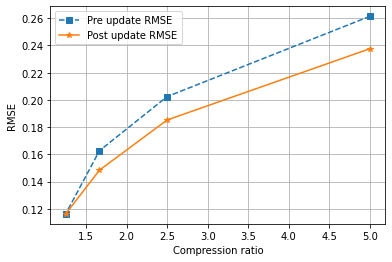

In [16]:
comp_ratios  = []
for i,z in enumerate(range(2, 10, 2)):
    n_measurements = (z* n_features)//10
    comp_ratio = n_features / n_measurements
    comp_ratios.append(comp_ratio)
    print(f"----------------- Compression Ratio: {comp_ratio:.2f} ----------------------")
    print(f"Pre update RMSE: {pre_update_rmse[i]:.2f}")
    print(f"Post update RMSE: {post_update_rmse[i]:.2f}")


plt.plot(comp_ratios, pre_update_rmse, 's--', label = f"Pre update RMSE")
plt.plot(comp_ratios, post_update_rmse, '*-', label = f"Post update RMSE")
plt.xlabel("Compression ratio")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()